#**Analysis by Caroline Robinson for Question 1 and 2 of CPSC-392 Final Project**



In [1]:
import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sb

# ML imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

In [2]:
df = pd.read_csv("/content/Life Expectancy Data.csv")
pd.set_option('display.max_columns', None)
print(df.shape)
df.head()

(2938, 22)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
features_list = df.columns.tolist() # whitespace issues with dataframe, done to easily see feature names
# features_list

#**Data Preparation**

In [ ]:
df.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [ ]:
num_features = ['Year', 'Life expectancy ', 'Adult Mortality', 'infant deaths',
            'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ',
            ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
            'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
            ' thinness  1-19 years', ' thinness 5-9 years',
            'Income composition of resources', 'Schooling']

for column in num_features:
    mean_value = df[column].mean()
    df[column] = df[column].fillna(mean_value)

In [ ]:
df.isna().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
 BMI                               0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
 HIV/AIDS                          0
GDP                                0
Population                         0
 thinness  1-19 years              0
 thinness 5-9 years                0
Income composition of resources    0
Schooling                          0
dtype: int64

In [ ]:
# Found a solution on Stack Overflow:
# Detecting and Handling outliers with z-score filtering
# Source: https://stackoverflow.com/a/69001342

cols = df.select_dtypes('number').columns
df_sub = df.loc[:, cols]

lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3
df.loc[:, cols] = df_sub.where(lim, np.nan)
df.dropna(inplace=True)

In [ ]:
df.shape

(2184, 22)

##**Q1: Linear Regression, Lasso, and Ridge**
**When predicting life expectancy based on health and economic indicators, does regularization techniques improve the model’s performance? If so, which does more, Lasso or Ridge?**

In [ ]:
predictors = ['Alcohol', 'percentage expenditure', 'Hepatitis B',
              'Measles ', ' BMI ', 'Polio', 'Total expenditure',
              'Diphtheria ', ' HIV/AIDS', 'GDP', 'Income composition of resources']

X = df[predictors]
y = df['Life expectancy ']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.1, random_state=10)

pre = make_column_transformer((StandardScaler(), predictors),
                            remainder = "passthrough")

###Linear Regression Model

In [ ]:
# linear regression
lr = LinearRegression()

pipe = Pipeline([("pre", pre),
                ("lr", lr)])

pipe.fit(X_train,y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

coefficients = lr.coef_
print("LR Coefficients:", coefficients)

LR Coefficients: [ 0.02578777  0.44282873 -0.55149665 -0.04430255  0.28189352  0.30060621
  0.4980138   1.45403325 -2.22788792 -0.23934876  5.13319822]


In [ ]:
# LR performance
print("LR TRAIN METRICS")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_squared_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("LR TEST METRICS")
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_squared_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))

LR TRAIN METRICS
Train MSE :  13.747858851129552
Train MAE :  2.6678978154640665
Train MAPE:  13.747858851129552
Train R2  :  0.8167736135524668
LR TEST METRICS
Test MSE  :  12.42773050711612
Test MAE  :  2.503843351479566
Test MAPE :  12.42773050711612
Test R2   :  0.8198293605921796


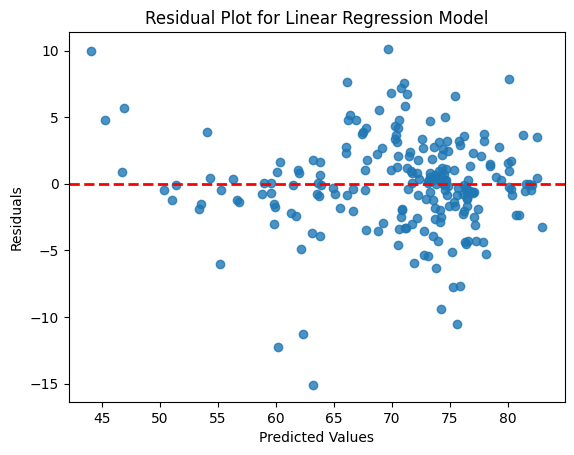

In [ ]:
# creating a residual plot
residuals_lr = y_test - y_pred_test

plt.scatter(y_pred_test, residuals_lr, alpha=.8)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot for Linear Regression Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
lr_plot = plt.show()

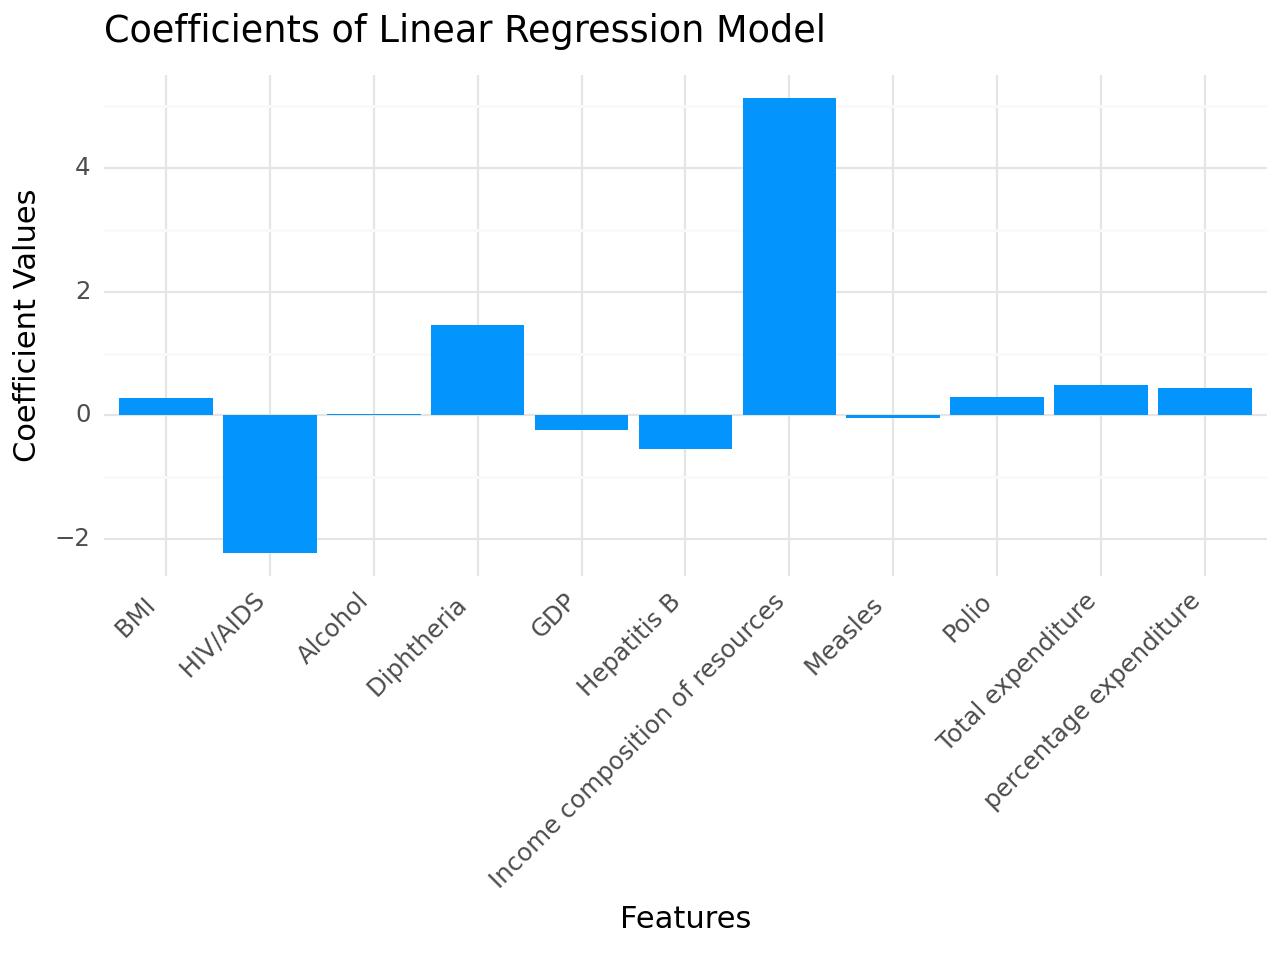

<Figure Size: (640 x 480)>

In [ ]:
# visualizing the coefficients for the predictors
feature_names = X.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

(ggplot(coef_df, aes(x='Feature', y='Coefficient')) +
     geom_col(fill='#0394fc') +
     theme_minimal() +
     ggtitle('Coefficients of Linear Regression Model') +
     xlab('Features') +
     ylab('Coefficient Values') +
     theme(axis_text_x=element_text(angle=45, hjust=1)))


###Regularization: Lasso

In [ ]:
# lasso
lasso = LassoCV(alphas=[0.1, 0.01, 0.001])

pipe = Pipeline([("pre", pre),
                ("lasso", lasso)])

pipe.fit(X_train,y_train)

# Get the optimal alpha (aka regularization strength)
optimal_alpha = lasso.alpha_
print(f"Optimal alpha: {optimal_alpha}")

Optimal alpha: 0.01


In [ ]:
lasso = LassoCV(alphas=[0.01])

pipe = Pipeline([("pre", pre),
                ("lasso", lasso)])

pipe.fit(X_train,y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

coefficients = lasso.coef_
print("Lasso Coefficients:", coefficients)

Lasso Coefficients: [ 0.02407491  0.39302506 -0.53178394 -0.03552573  0.2768459   0.29628181
  0.49694073  1.44194599 -2.22288531 -0.18052326  5.12755385]


In [ ]:
# Lasso performance
print("LASSO TRAIN METRICS")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_squared_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("LASSO TEST METRICS")
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_squared_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))

LASSO TRAIN METRICS
Train MSE :  13.749576692925068
Train MAE :  2.668370960620378
Train MAPE:  13.749576692925068
Train R2  :  0.8167507187913198
LASSO TEST METRICS
Test MSE  :  12.40910382042861
Test MAE  :  2.5020941613443153
Test MAPE :  12.40910382042861
Test R2   :  0.8200994004074633


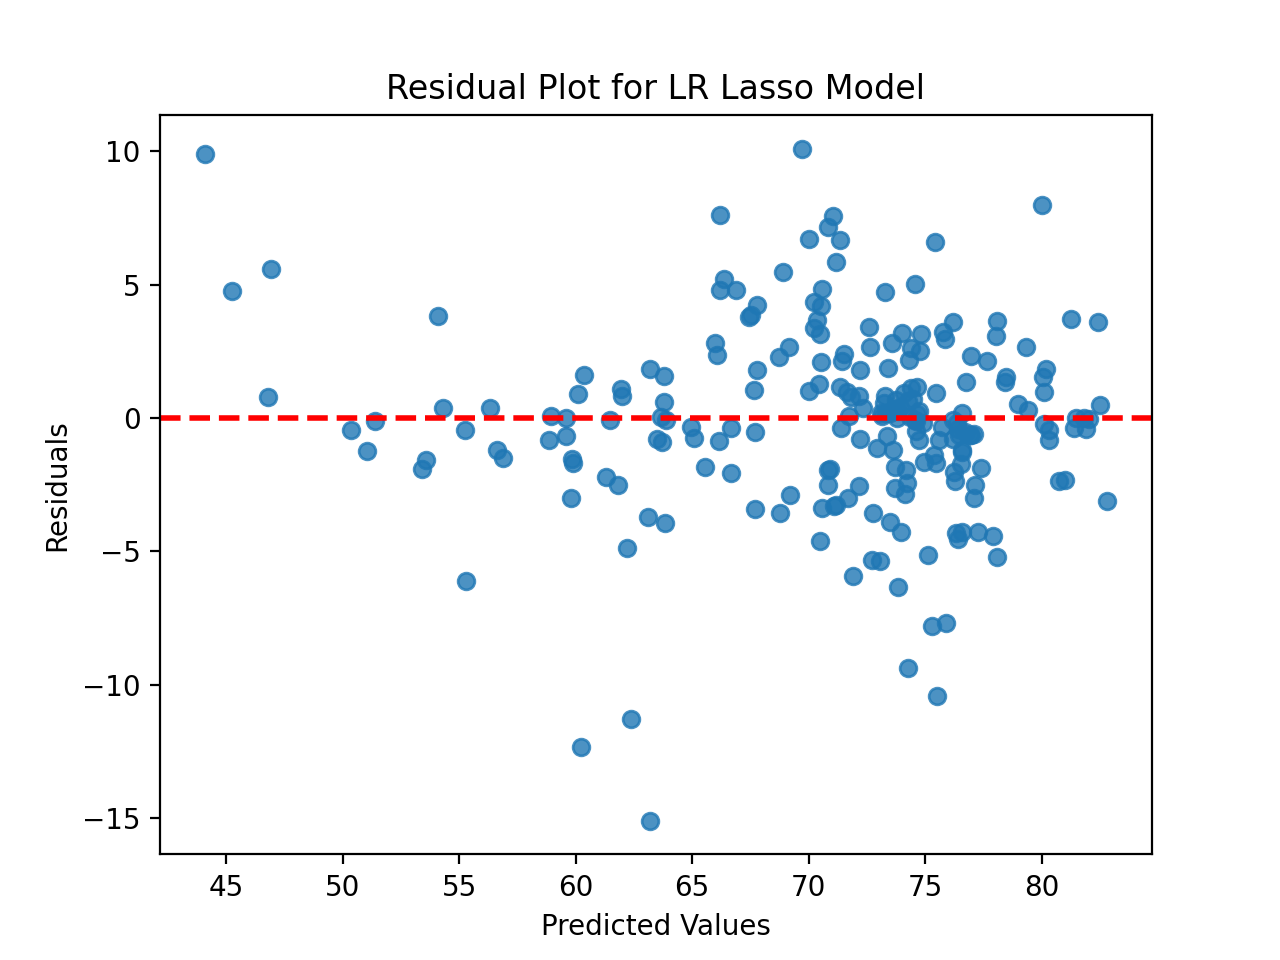

In [ ]:
# creating a residual plot
residuals_lasso = y_test - y_pred_test

plt.scatter(y_pred_test, residuals_lasso, alpha=.8)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot for LR Lasso Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
lr_plot = plt.show()

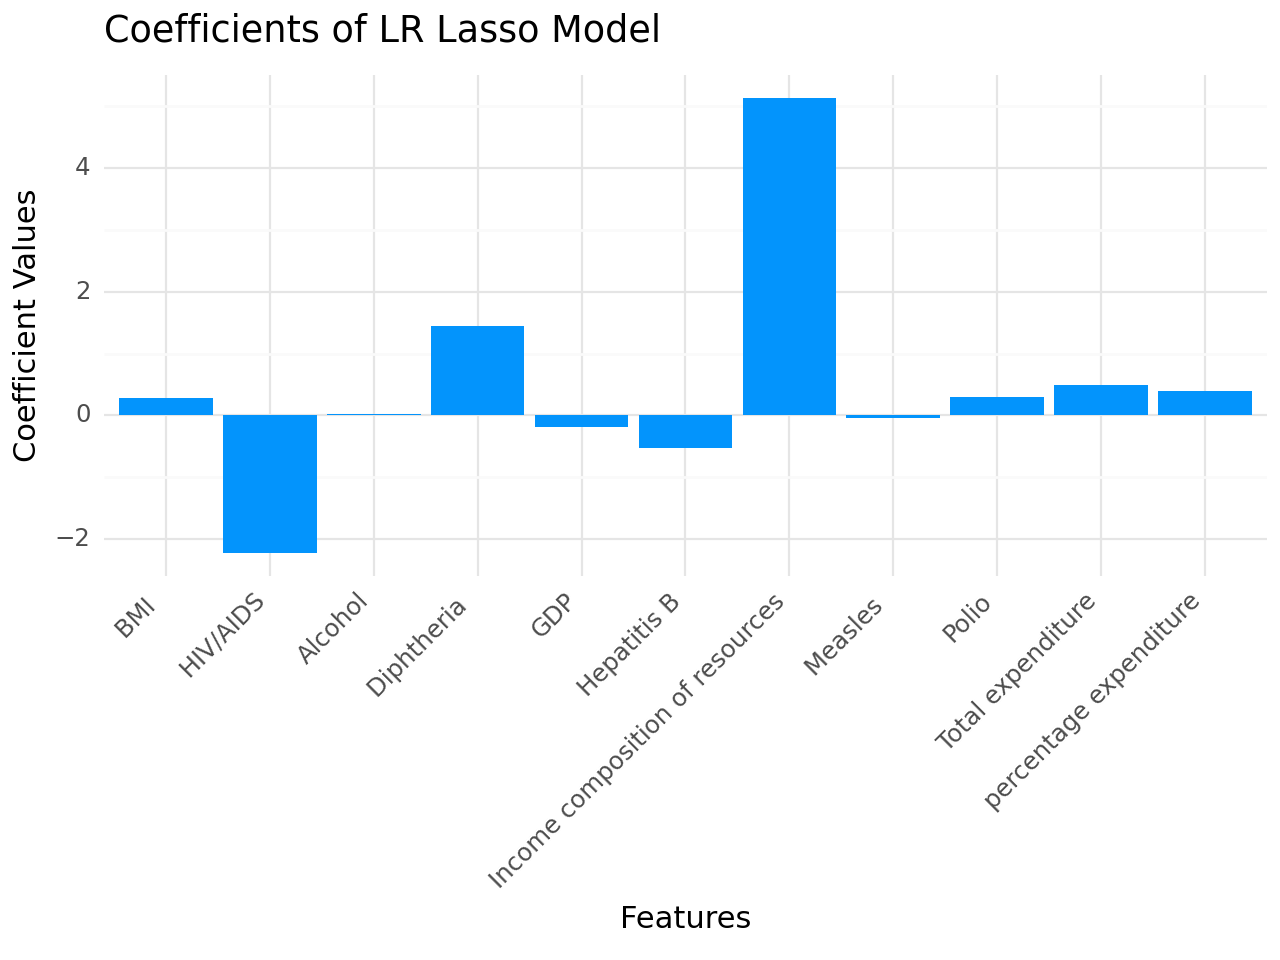

<Figure Size: (640 x 480)>

In [ ]:
# visualizaing coefficients
feature_names = X.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

(ggplot(coef_df, aes(x='Feature', y='Coefficient')) +
     geom_col(fill='#0394fc') +
     theme_minimal() +
     ggtitle('Coefficients of LR Lasso Model') +
     xlab('Features') +
     ylab('Coefficient Values') +
     theme(axis_text_x=element_text(angle=45, hjust=1)))

###Regularization: Ridge

In [ ]:
# ridge
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])

pipe = Pipeline([("pre", pre),
                ("ridge", ridge)])

pipe.fit(X_train,y_train)

# Get the optimal alpha (aka regularization strength)
optimal_alpha = ridge.alpha_
print(f"Optimal alpha: {optimal_alpha}")

Optimal alpha: 10.0


In [ ]:
ridge = RidgeCV(alphas=10.0)

pipe = Pipeline([("pre", pre),
                ("ridge", ridge)])

pipe.fit(X_train,y_train)

y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

coefficients = lasso.coef_
print("Coefficients:", coefficients)

Coefficients: [ 0.02407491  0.39302506 -0.53178394 -0.03552573  0.2768459   0.29628181
  0.49694073  1.44194599 -2.22288531 -0.18052326  5.12755385]


In [ ]:
# ridge performance
print("RIDGE TRAIN METRICS")
print("Train MSE : ", mean_squared_error(y_train,y_pred_train))
print("Train MAE : ", mean_absolute_error(y_train,y_pred_train))
print("Train MAPE: ", mean_squared_error(y_train,y_pred_train))
print("Train R2  : ", r2_score(y_train,y_pred_train))

print("RIDGE TEST METRICS")
print("Test MSE  : ", mean_squared_error(y_test,y_pred_test))
print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))
print("Test MAPE : ", mean_squared_error(y_test,y_pred_test))
print("Test R2   : ", r2_score(y_test,y_pred_test))

RIDGE TRAIN METRICS
Train MSE :  13.749926255191973
Train MAE :  2.6712472572126784
Train MAPE:  13.749926255191973
Train R2  :  0.8167460599545003
RIDGE TEST METRICS
Test MSE  :  12.42570856665708
Test MAE  :  2.5085109324873014
Test MAPE :  12.42570856665708
Test R2   :  0.8198586736115712


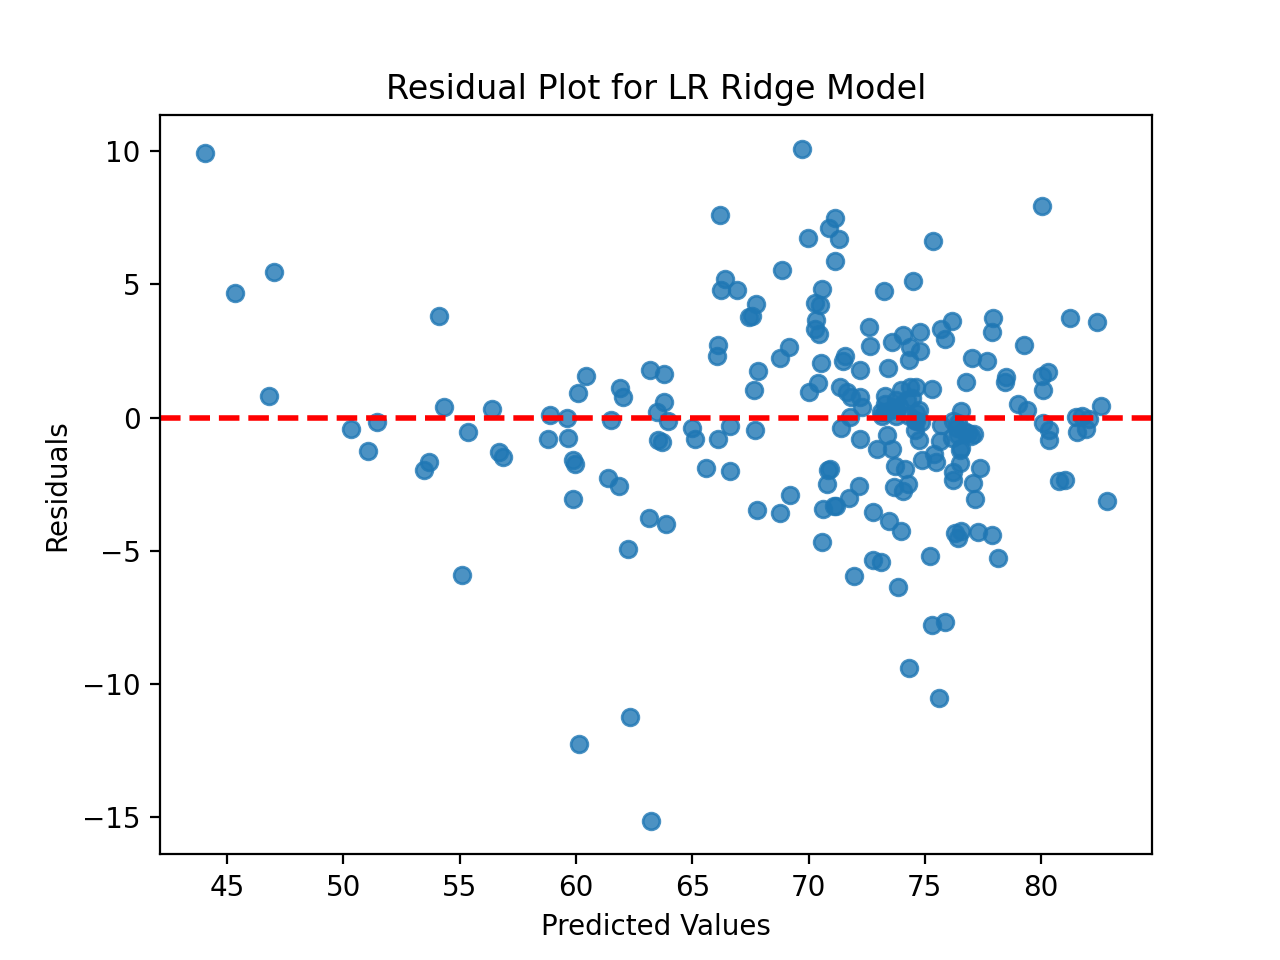

In [ ]:
# creating a residual plot
residuals_ridge = y_test - y_pred_test

plt.scatter(y_pred_test, residuals_ridge, alpha=.8)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot for LR Ridge Model')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
lr_plot = plt.show()

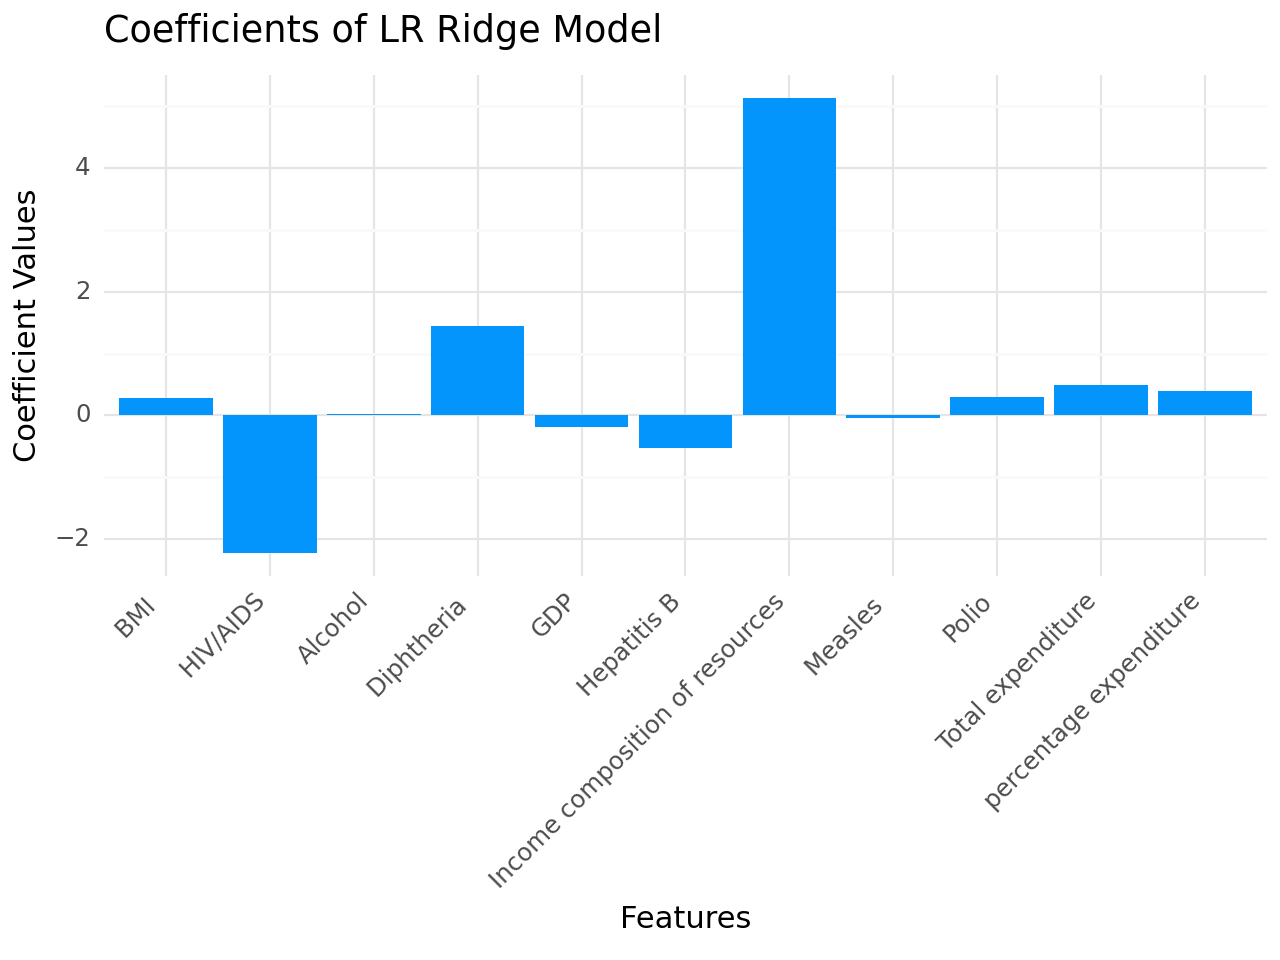

<Figure Size: (640 x 480)>

In [ ]:
# visualizing coefficients
feature_names = X.columns
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

(ggplot(coef_df, aes(x='Feature', y='Coefficient')) +
     geom_col(fill='#0394fc') +
     theme_minimal() +
     ggtitle('Coefficients of LR Ridge Model') +
     xlab('Features') +
     ylab('Coefficient Values') +
     theme(axis_text_x=element_text(angle=45, hjust=1)))

##**Q2: Dimensionality Reduction analysis**
**Would performing PCA on the whole data set improve K-Means clustering more than performing PCA on select features? When focusing on life expectancy, which variables are highly correlated and would benefit from PCA, and which ones would be better off without PCA, if any?**

Axes(0.125,0.11;0.62x0.77)


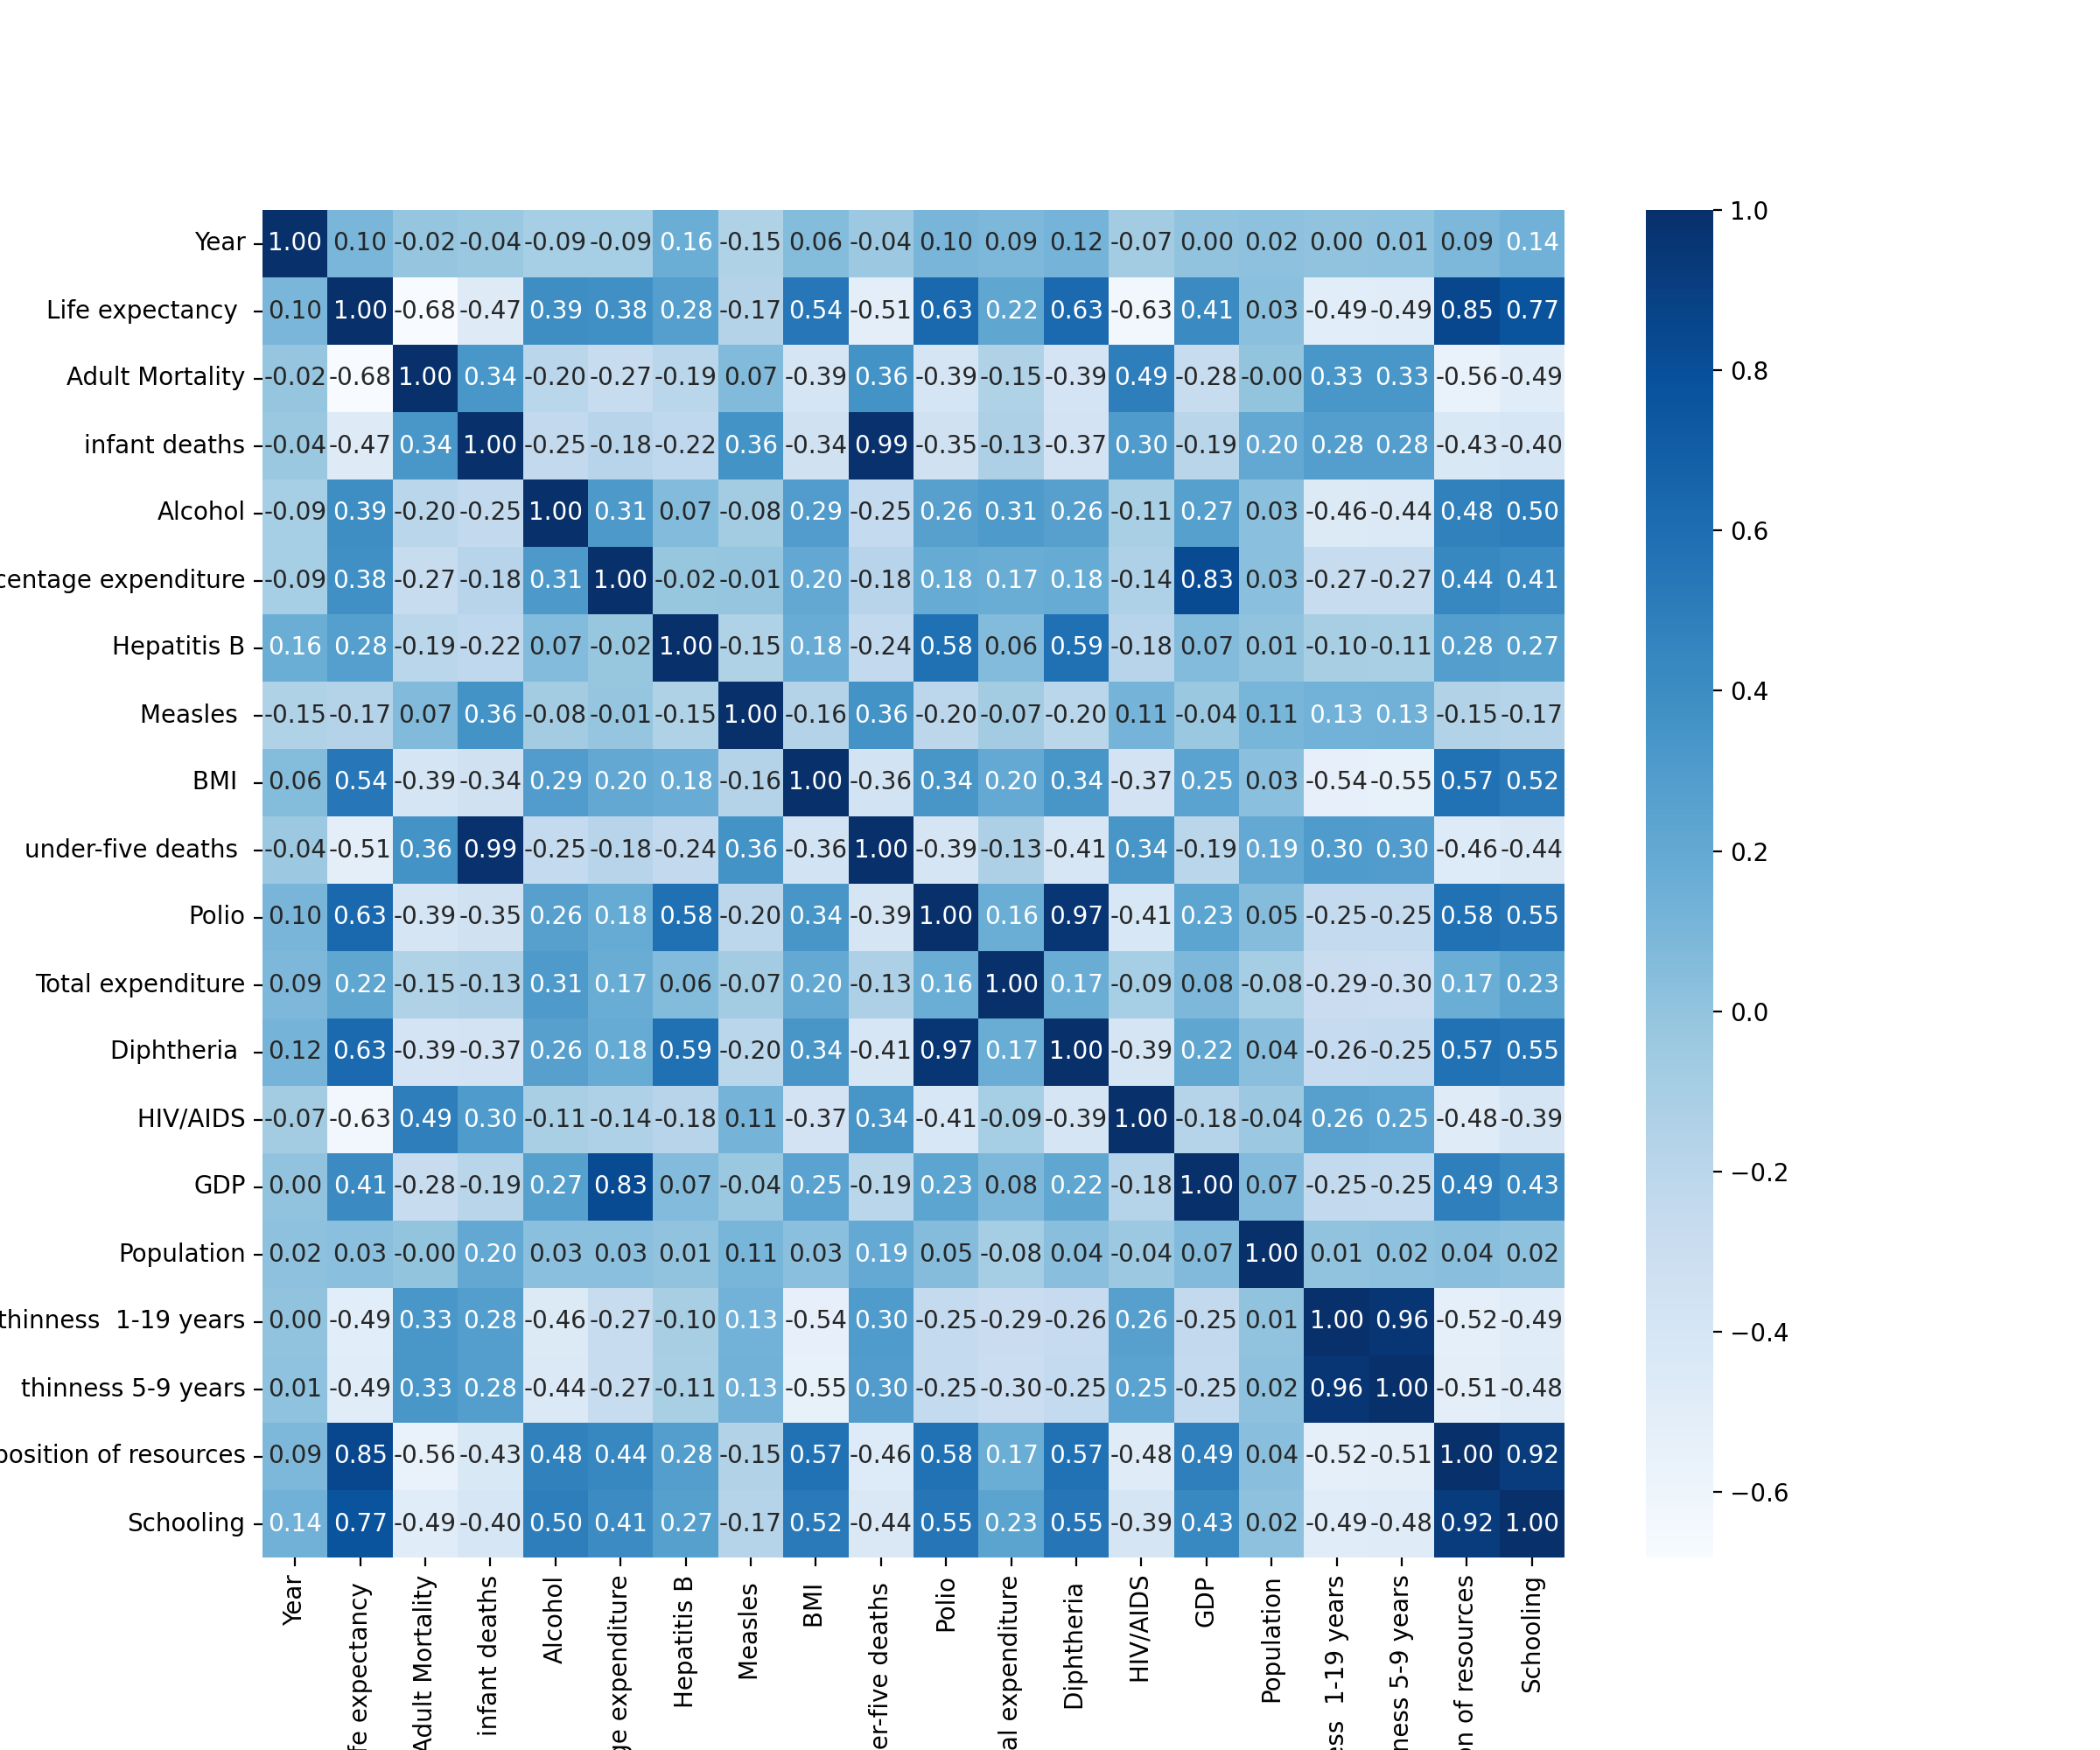

In [ ]:
plt.figure(figsize=(12, 10))
print(sb.heatmap(df.corr(), cmap = "Blues", fmt='.2f', annot = True))
feats = ["V" + str(i) for i in range(1,12)]

In [ ]:
all_feats = ['Life expectancy ', 'Adult Mortality', 'infant deaths',
            'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ',
            ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
            'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
            ' thinness  1-19 years', ' thinness 5-9 years',
            'Income composition of resources', 'Schooling']

X_all = df[all_feats]

z_all = make_column_transformer((StandardScaler(), all_feats),
                            remainder = "passthrough")

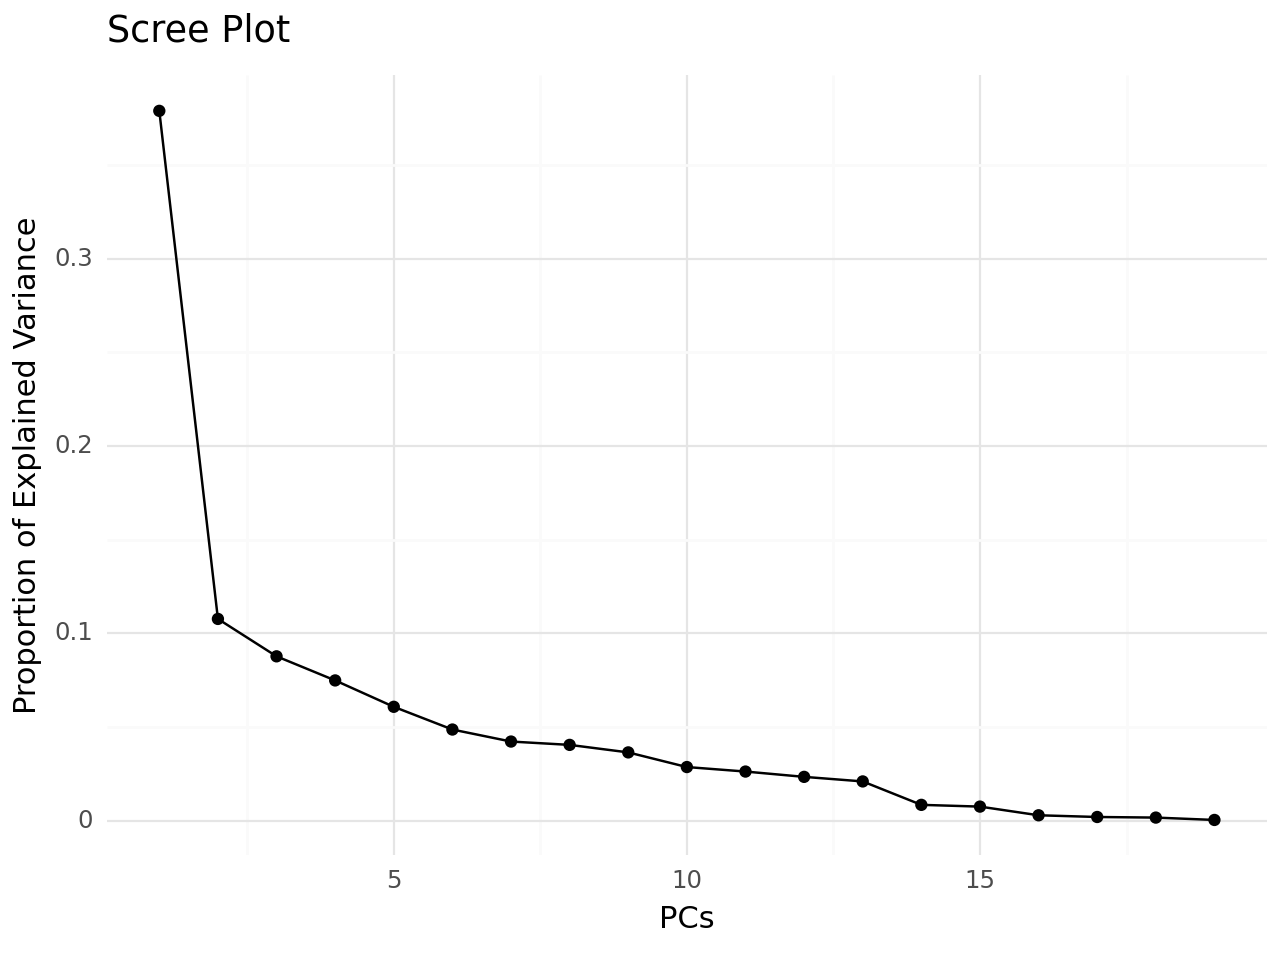

In [ ]:
pca = PCA()

pipe = Pipeline([
    ("z", z_all),
    ("pca", pca)
])

pipe.fit(X_all)

pcaDF = pd.DataFrame({"expl_var" :
                      pipe.named_steps["pca"].explained_variance_ratio_,
                      "pc": range(1,20),
                      "cum_var":
                      pipe.named_steps["pca"].explained_variance_ratio_.cumsum()})

print(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
 theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

In [ ]:
# only features with high correlation to life expectancy
selected_feats = ['Year', 'Life expectancy ','Alcohol', 'percentage expenditure', 'Hepatitis B',
            ' BMI ', 'Polio', 'Total expenditure', 'Diphtheria ', 'GDP', 'Population',
            'Income composition of resources', 'Schooling']

X_selected = df[selected_feats]

z_selected = make_column_transformer((StandardScaler(), selected_feats),
                            remainder = "passthrough")

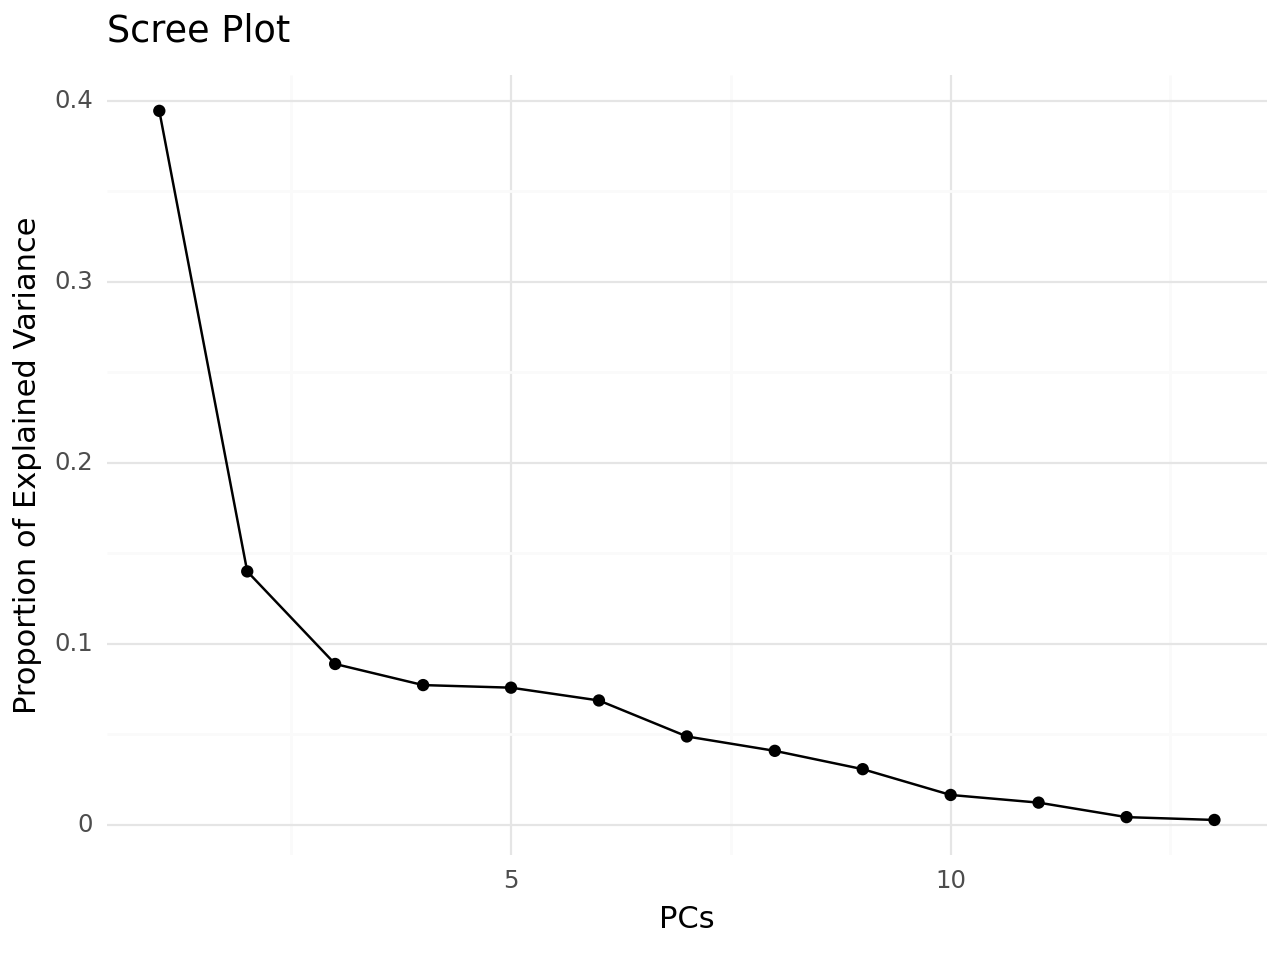

In [ ]:
pca = PCA()

pipe = Pipeline([
    ("z", z_selected),
    ("pca", pca)
])

pipe.fit(X_selected)

pcaDF = pd.DataFrame({"expl_var" :
                      pipe.named_steps["pca"].explained_variance_ratio_,
                      "pc": range(1,14),
                      "cum_var":
                      pipe.named_steps["pca"].explained_variance_ratio_.cumsum()})

print(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point() +
 theme_minimal() + labs(x = "PCs", y = "Proportion of Explained Variance", title = "Scree Plot"))

In [ ]:
pca_all = PCA(2)

X_all_pca = pca.fit_transform(X_all)
all_df = pd.DataFrame(X_all_pca)

pca_selected = PCA(3)

X_selected_pca = pca.fit_transform(X_selected)
selected_df = pd.DataFrame(X_selected_pca)

In [ ]:
metrics = {"SSE": [], "sil": [], "k": []}

for i in range(2,11):
    km = KMeans(i)
    pipe = Pipeline([
        ("pre", z_all),
        ("km", km)
    ])

    labels = pipe.fit_predict(X_all[all_feats])
    sil = silhouette_score(X_all[all_feats], labels)
    sse = pipe.named_steps["km"].inertia_

    metrics["SSE"].append(sse)
    metrics["sil"].append(sil)
    metrics["k"].append(i)

df_metrics = pd.DataFrame(metrics)


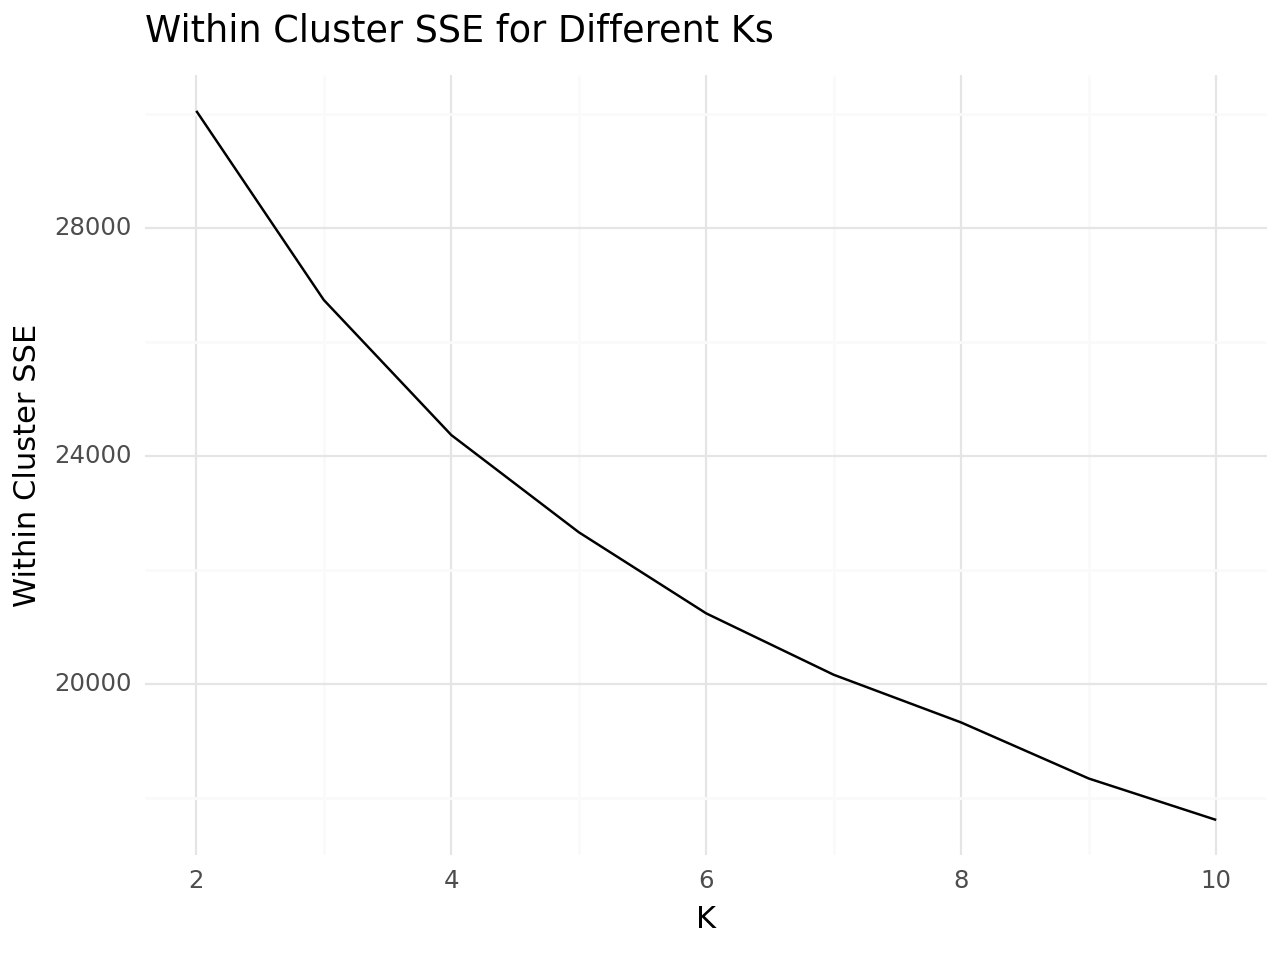

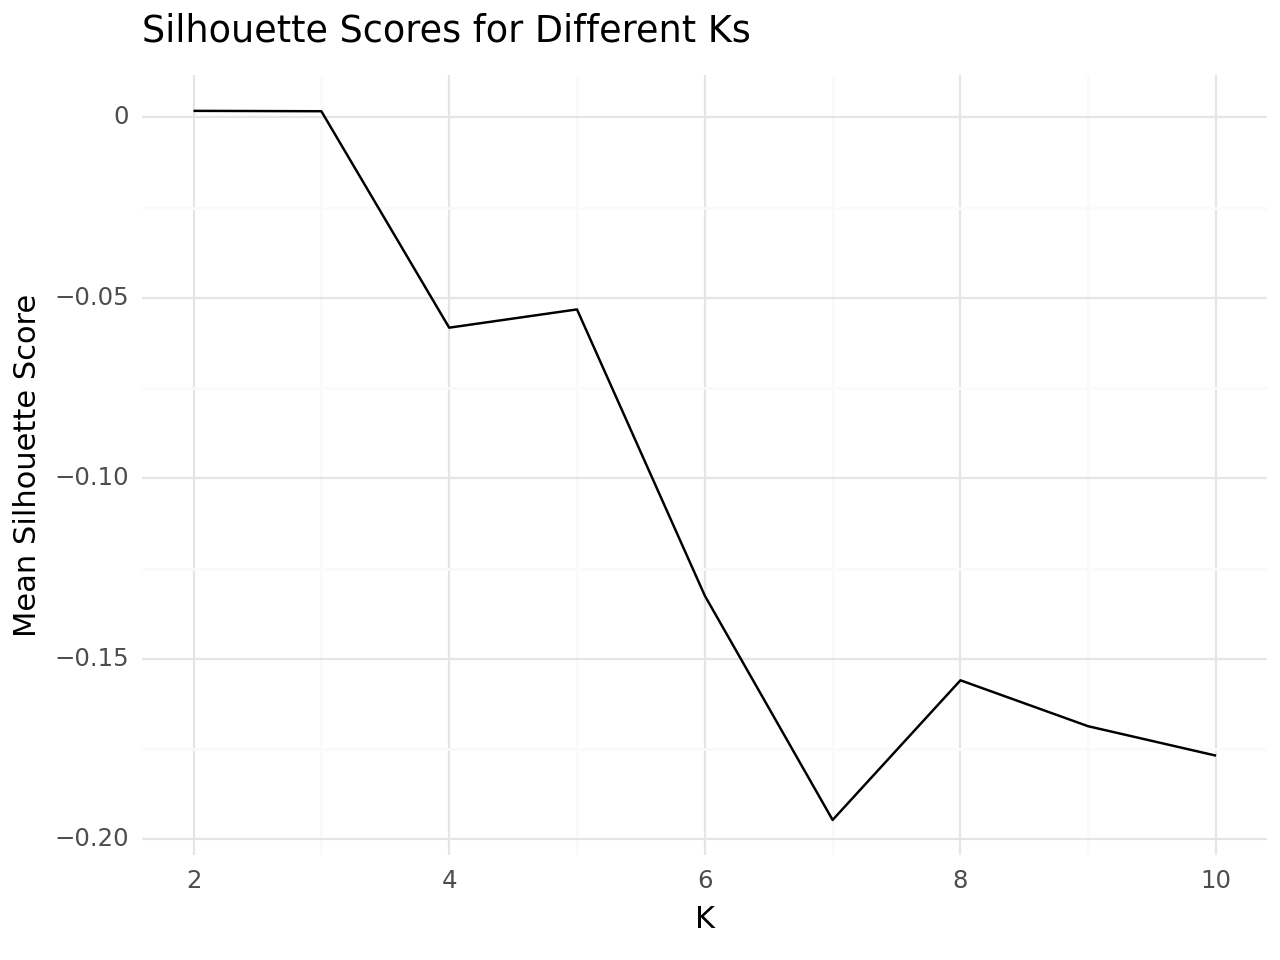

In [ ]:
print(ggplot(df_metrics, aes(x = "k", y = "SSE")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Within Cluster SSE",
         title = "Within Cluster SSE for Different Ks"))

print(ggplot(df_metrics, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))

In [ ]:
feats = [0, 1]
X1 = all_df[feats]

km = KMeans(3)

labels = km.fit_predict(X1[feats])

X1["cluster"] = labels

In [ ]:
silhouette_avg = silhouette_score(X1, labels)
silhouette_avg

0.747744878494926

In [ ]:
metrics = {"SSE": [], "sil": [], "k": []}

for i in range(2,11):
    km = KMeans(i)
    pipe = Pipeline([
        ("pre", z_selected),
        ("km", km)
    ])

    labels = pipe.fit_predict(X_selected[selected_feats])
    sil = silhouette_score(X_selected[selected_feats], labels)
    sse = pipe.named_steps["km"].inertia_

    metrics["SSE"].append(sse)
    metrics["sil"].append(sil)
    metrics["k"].append(i)

df_metrics = pd.DataFrame(metrics)


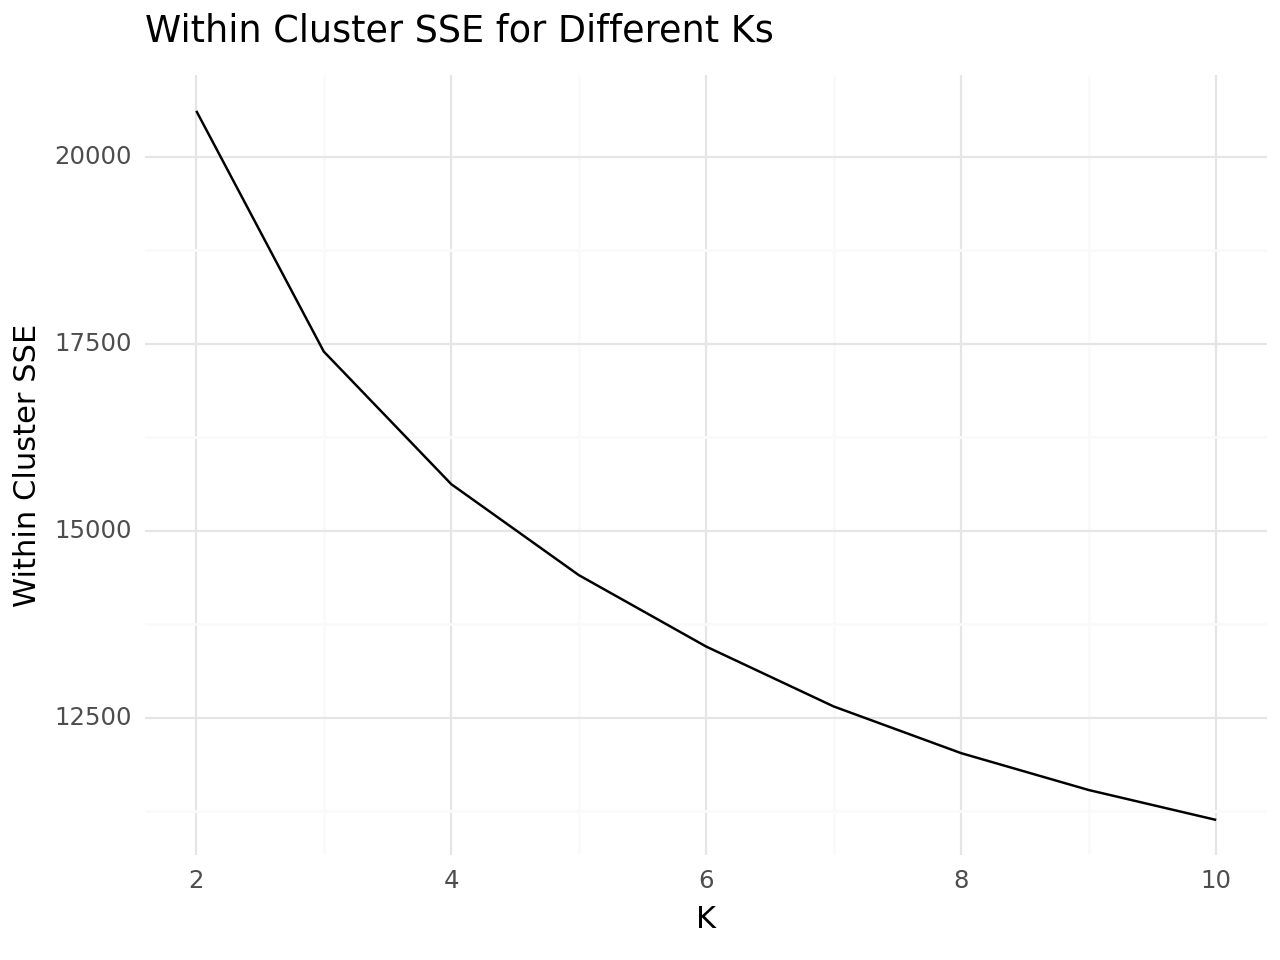

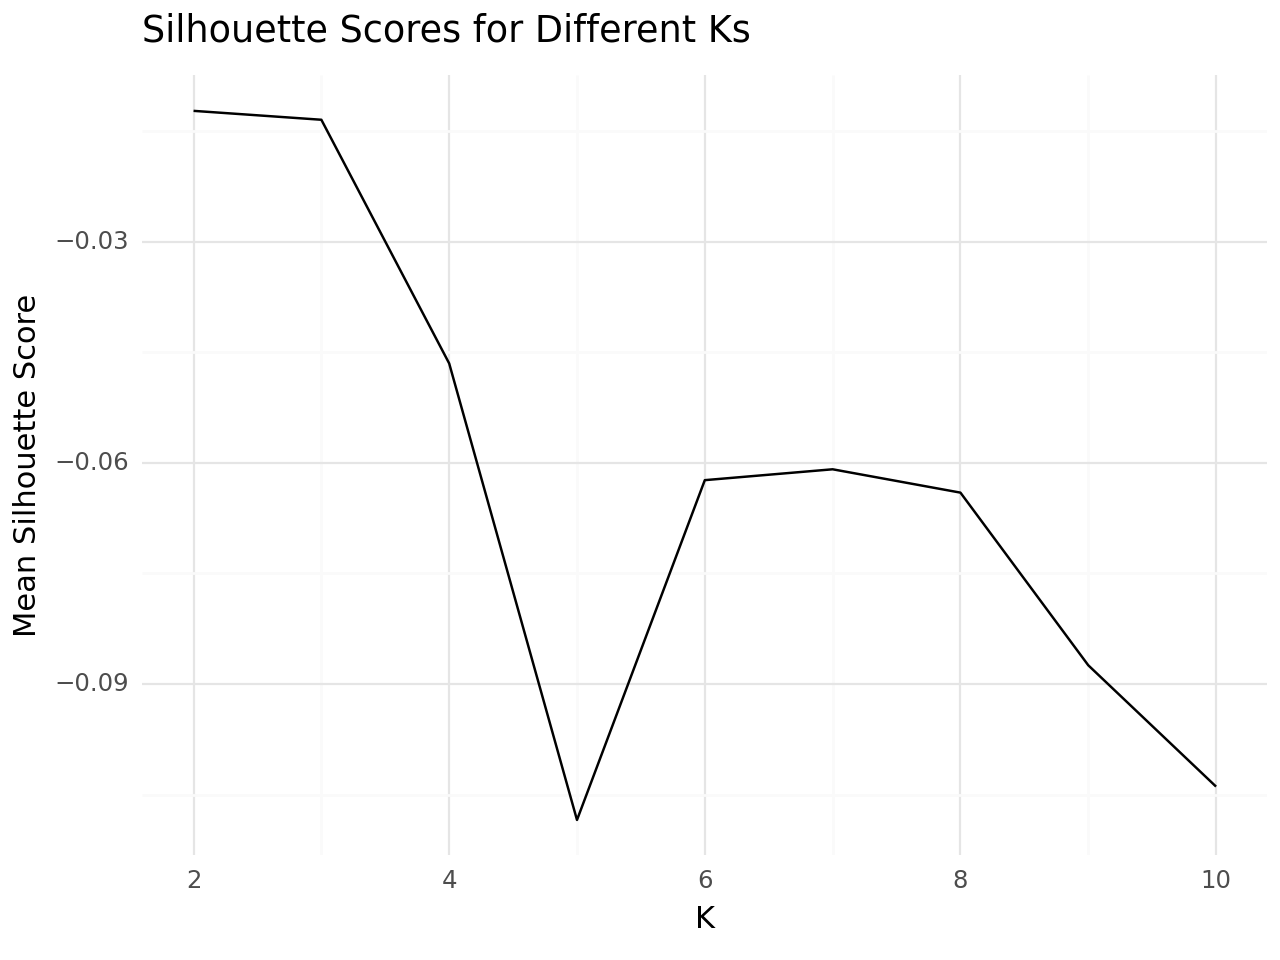

In [ ]:
print(ggplot(df_metrics, aes(x = "k", y = "SSE")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Within Cluster SSE",
         title = "Within Cluster SSE for Different Ks"))

print(ggplot(df_metrics, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))

In [ ]:
feats = [0, 1, 2]
X2 = selected_df[feats]

km = KMeans(3)

labels = km.fit_predict(X2[feats])

X2["cluster"] = labels

In [ ]:
silhouette_avg = silhouette_score(X2, labels)
silhouette_avg

0.7477446330184019